In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt

from la_forge.core import Core

import defiant
from defiant import OptimalStatistic
from defiant import utils, orf_functions, null_distribution as nulls
from defiant import plotting as defplot

from defiant.extra import mdc1_utils


print("Using defiant from:",defiant.__file__)

Using defiant from: /Users/gersbaka/Documents/Projects/Software_dev/defiant/defiant/__init__.py


In [2]:
# Returns both the list of pulsars and the injected parameters
psrs,inj_params = mdc1_utils.get_MDC1_psrs() 
# Create the PTA based on the pulsars loaded
pta = mdc1_utils.create_MDC1_PTA(psrs, gwb_components=10, gwb_name='gw') 


# For future plots, we will want the injected spectrum too
fgw = utils.get_pta_frequencies(pta, gwb_name='gw') # You can also get this with os_obj.freqs
inj_spectrum = utils.powerlaw(fgw, inj_params['gw_log10_A'], inj_params['gw_gamma'])

Loading MDC1 psrs:   0%|          | 0/36 [00:00<?, ?it/s]

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


In [3]:
to_sample = False

if to_sample:
    from enterprise_extensions.sampler import setup_sampler

    chain_loc = 'MDC1_FG_CURN_samples/'

    # Use enterprise_extensions setup_sampler to speed up the process!
    sampler = setup_sampler(pta, chain_loc, resume=True, human='KAG')

    x0 = np.hstack([p.sample() for p in pta.params]) # Get an initial sample

    sampler.sample(x0, Niter=int(1e6)) # Run a million samples

    lfcore = Core(chaindir=chain_loc)

    lfcore.save('MDC1_FG_CURN_samples.core')
    
else:
    # Load in the core object
    lfcore = Core(corepath='./MDC1_FG_CURN_samples.core')

In [4]:
# Since we created our PTA object with 'gw' as the name, make sure to set that!
OS_obj = OptimalStatistic(psrs, pta=pta, gwb_name='gw', core=lfcore, orfs=['hd'])

13.14986296019562


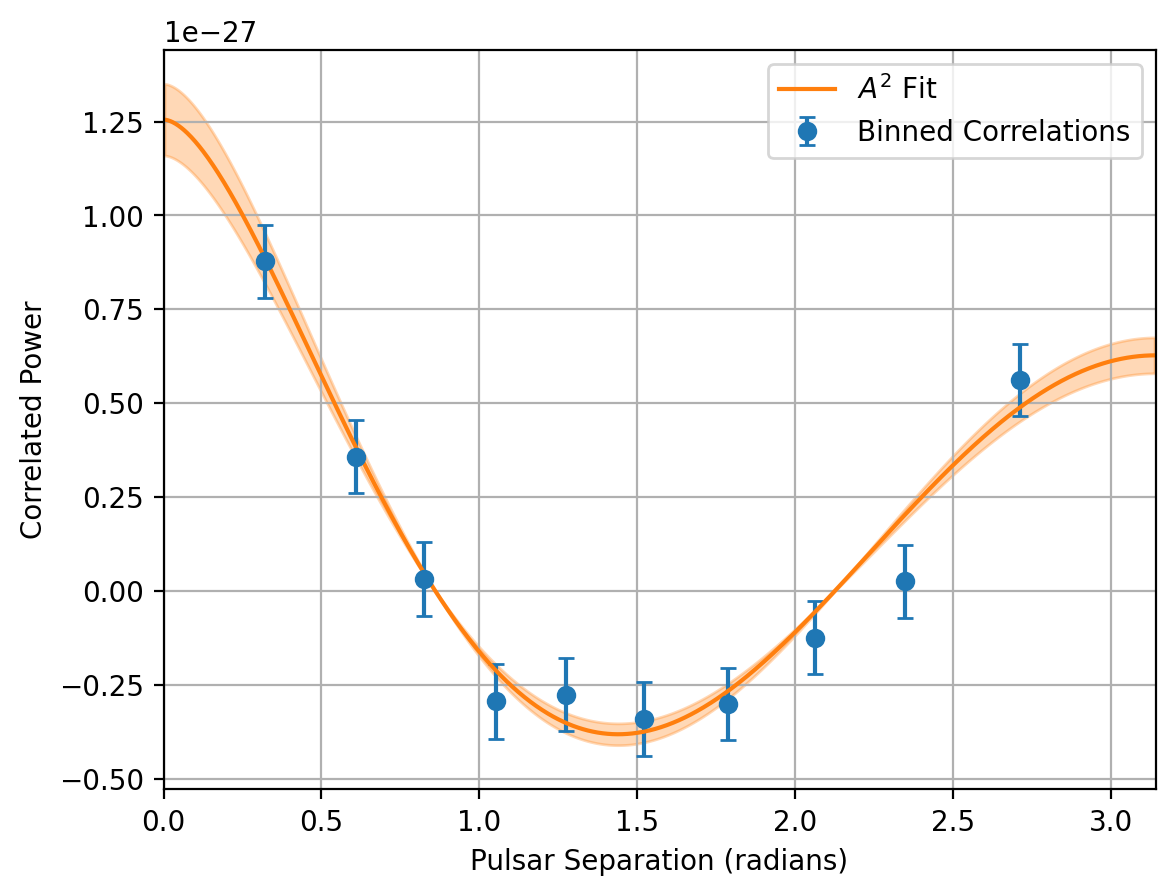

In [116]:
xi,rho,sig,C,A2,A2s,idx = OS_obj.compute_OS(params=inj_params)

defplot.create_correlation_plot(xi,rho,sig,C,A2,A2s,bins=10)
print(A2/A2s)

In [99]:
import scipy.linalg as sl

def random_rotation_matrix(npulsar, ndim, rng=None):
    """A function to generate a block diagonal matrix of random rotations in 2D.

    This function is specifically designed to work with matrices where there are
    sines and cosines for each frequency (i.e. where the diagonal represents 
    [f0_sine, f0_cosine, f1_sine, f1_cosine, ...]). This is useful for phase shifts
    in the optimal statistic's rank-reduced fourier representations.

    Args:
        npulsar (int): The number of pulsars in the PTA.
        ndim (int): The number of dimensions in the matrix. Must be even.
        rng (numpy.random._generator.Generator, optional): A random number generator. 
            Defaults to None.

    Returns:
        numpy.ndarray: The random rotation matrix of shape (npulsar x ndim x ndim).
    """
    if rng is None:
        rng = np.random.default_rng()
    
    R = np.zeros((npulsar, ndim, ndim))
    for i in range(npulsar):
        rand_phi = np.random.uniform(0, 2*np.pi, ndim//2)
        rand_phi = rng.uniform(0, 2*np.pi, ndim//2)
    
        cos_phi = np.cos(rand_phi)
        sin_phi = np.sin(rand_phi)
    
        # Create sub-blocks of block diagonal matrix
        blocks = np.zeros((ndim//2, 2, 2))
        blocks[:,0,0] = cos_phi
        blocks[:,1,0] = -sin_phi
        blocks[:,0,1] = sin_phi
        blocks[:,1,1] = cos_phi

        # block_diag requires each block to be its own argument. We can unpack the 
        # blocks by using list comprehension and the * operator. 
        # (numpy doesn't support unpacking natively)
        R_pulsar = sl.block_diag(*[b for b in blocks])
        R[i] = R_pulsar
        
    return R


In [106]:
R = random_rotation_matrix(3,8)
with np.printoptions(precision=3, suppress=True):
    print(R[0])
    print(R[1])

[[ 0.391 -0.92   0.     0.     0.     0.     0.     0.   ]
 [ 0.92   0.391  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.143 -0.99   0.     0.     0.     0.   ]
 [ 0.     0.     0.99   0.143  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.997  0.076  0.     0.   ]
 [ 0.     0.     0.     0.    -0.076  0.997  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -0.144 -0.99 ]
 [ 0.     0.     0.     0.     0.     0.     0.99  -0.144]]
[[-0.415  0.91   0.     0.     0.     0.     0.     0.   ]
 [-0.91  -0.415  0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.554 -0.832  0.     0.     0.     0.   ]
 [ 0.     0.     0.832  0.554  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.    -0.951 -0.311  0.     0.   ]
 [ 0.     0.     0.     0.     0.311 -0.951  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -0.848 -0.53 ]
 [ 0.     0.     0.     0.     0.     0.     0.53  -0.848]]


In [120]:
from defiant.null_distribution import phase_shift_OS


p,snr,n_dist = phase_shift_OS(OS_obj,inj_params,n_shifts=10000)
print(p, snr)

shifts:   0%|          | 0/10000 [00:00<?, ?it/s]

0.0 13.14986296019562


P-value: 0.0


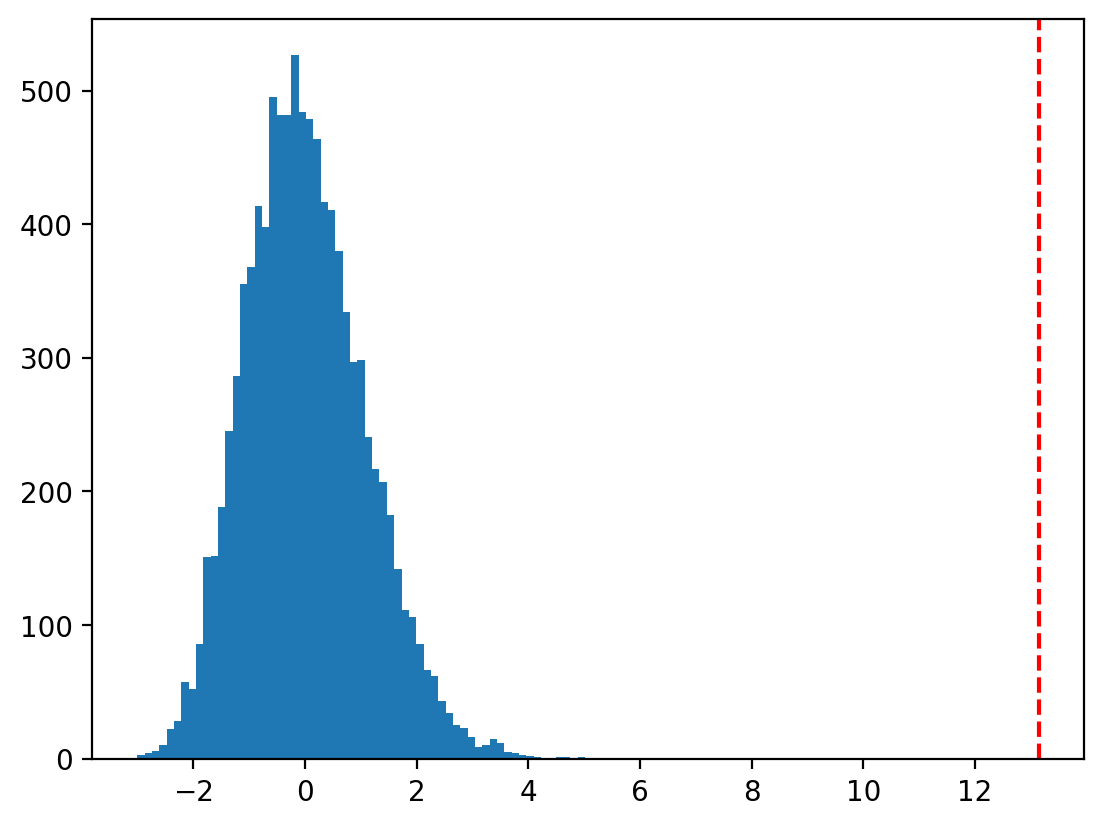

In [121]:
plt.hist(n_dist,bins='auto');
plt.axvline(snr, color='r', linestyle='--')
print('P-value:',p)